In [12]:
# Step 1: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt

# Step 2: Download TATA Motors stock data
start = dt.datetime(2015, 1, 1)
end = dt.datetime.now()

# TATA Motors NSE symbol
data = yf.download('TATAMOTORS.NS', start=start, end=end)

# Step 3: Display data
data.head()


C:\Users\Siddhesh Navgare\AppData\Local\Temp\ipykernel_37916\2253565779.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('TATAMOTORS.NS', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS
Date,,,,,
2015-01-01,484.241913,485.213400,478.218630,480.404507,944551
2015-01-02,497.211395,502.651786,483.076129,483.076129,4193093
2015-01-05,508.869324,511.006597,492.256764,495.559853,6758676
2015-01-06,487.107849,499.688704,485.019121,499.688704,7979598
2015-01-07,479.773041,486.136315,475.255563,480.890252,9232656


In [13]:
# Check missing values
print(data.isnull().sum())

# Fill missing values (forward fill)
data = data.ffill()

# Check for duplicates
print("Duplicates:", data.duplicated().sum())


Price   Ticker       
Close   TATAMOTORS.NS    0
High    TATAMOTORS.NS    0
Low     TATAMOTORS.NS    0
Open    TATAMOTORS.NS    0
Volume  TATAMOTORS.NS    0
dtype: int64
Duplicates: 0


In [14]:
# Moving averages
data['MA10'] = data['Close'].rolling(10).mean()
data['MA50'] = data['Close'].rolling(50).mean()

# Daily returns
data['Daily Return'] = data['Close'].pct_change()

# Volatility (20-day rolling std)
data['Volatility'] = data['Daily Return'].rolling(20).std()

data.tail()


Price,Close,High,Low,Open,Volume,MA10,MA50,Daily Return,Volatility
Ticker,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,,,,
Date,,,,,,,,,
2025-10-23,405.850006,408.899994,403.600006,407.500000,14126009,480.795001,649.215000,0.009954,0.091500
2025-10-24,403.299988,408.500000,401.000000,406.950012,6311744,453.015002,644.206000,-0.006283,0.091556
2025-10-27,410.049988,411.399994,403.649994,404.000000,10699376,426.125000,639.325000,0.016737,0.091914
2025-10-28,411.500000,414.149994,408.549988,411.299988,10332279,401.200000,634.280000,0.003536,0.091770
2025-10-29,411.350006,415.000000,407.049988,412.500000,8485023,402.789999,629.215001,-0.000365,0.091772


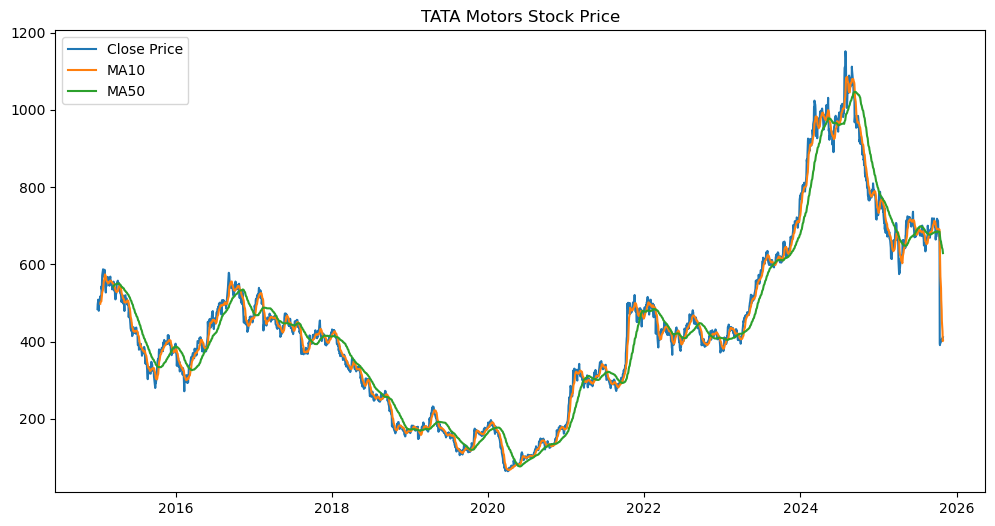

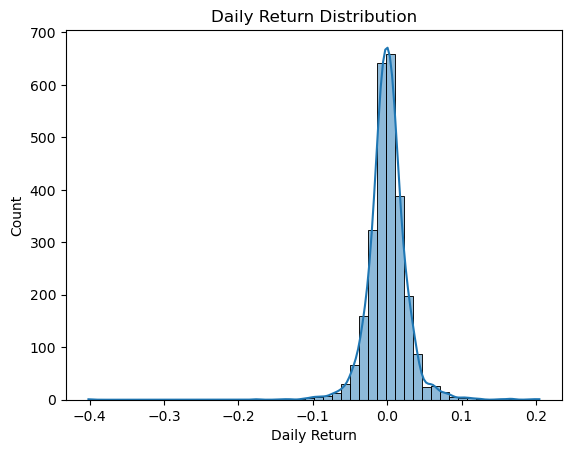

In [15]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['MA10'], label='MA10')
plt.plot(data['MA50'], label='MA50')
plt.title('TATA Motors Stock Price')
plt.legend()
plt.show()

# Daily returns distribution
sns.histplot(data['Daily Return'].dropna(), bins=50, kde=True)
plt.title('Daily Return Distribution')
plt.show()


In [16]:
from sklearn.preprocessing import MinMaxScaler

# Use only 'Close' column
close_data = data[['Close']].values

# Normalize
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_data)

# Split 80-20
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [17]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape for LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


C:\Users\Siddhesh Navgare\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0175 - val_loss: 2.5981e-04
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 9.2064e-04 - val_loss: 3.6809e-04
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 7.3399e-04 - val_loss: 4.3060e-04
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 7.2073e-04 - val_loss: 1.9771e-04
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 5.8852e-04 - val_loss: 6.6952e-04
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 5.4138e-04 - val_loss: 4.2079e-04
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 5.9891e-04 - val_loss: 3.3251e-04
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 4.3014e-04 - val_loss: 2.4288e-04
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 4.4471e-04 - val_loss: 1.7374e-04
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4.0642e-04 - val_loss: 2.6019e-04
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.7205e-04 - 

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


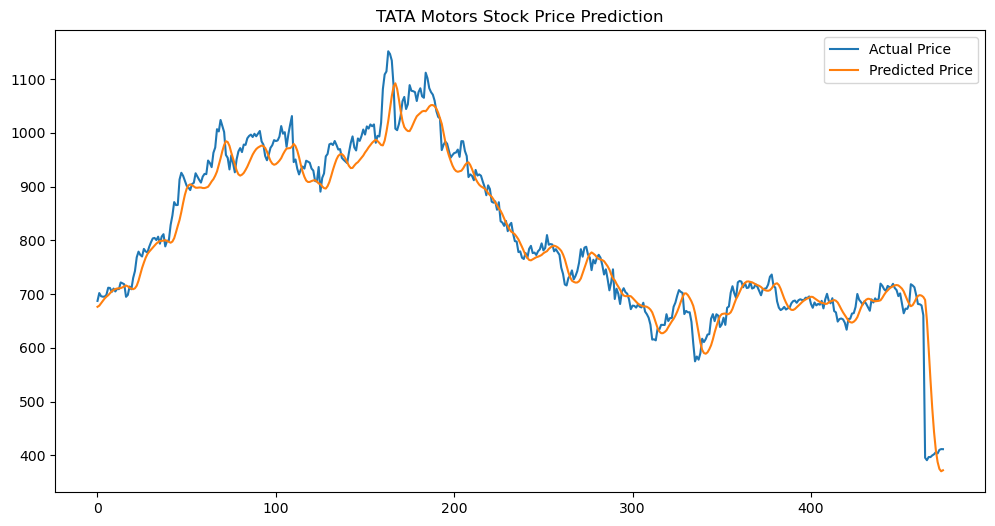

In [20]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('TATA Motors Stock Price Prediction')
plt.legend()
plt.show()


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
rmse = math.sqrt(mse)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MSE: 1402.45
MAE: 24.86
RMSE: 37.45


In [ ]:
import joblib
model.save("tata_lstm_model.h5")
joblib.dump(scaler, "scaler.pkl")
